# Exploratory Analysis Office Data & Fine-Tuning BERT

Lisa Gotzian, September 13-26, 2023

In [80]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

/var/folders/9l/8f8knqhj6r569g2lvlngfzdw0000gq/T/ipykernel_28127/2998138693.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [81]:
df = pd.read_csv('data/merged_export.csv', sep=";")

In [82]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
plt.hist(df["Office"])

(array([ 146., 1017.,  294.,  305.,  408.,  535., 1077.,  186.,  380.,
         524.]),
 array([ 0. ,  5.9, 11.8, 17.7, 23.6, 29.5, 35.4, 41.3, 47.2, 53.1, 59. ]),
 <BarContainer object of 10 artists>)

/var/folders/9l/8f8knqhj6r569g2lvlngfzdw0000gq/T/ipykernel_28127/838303.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


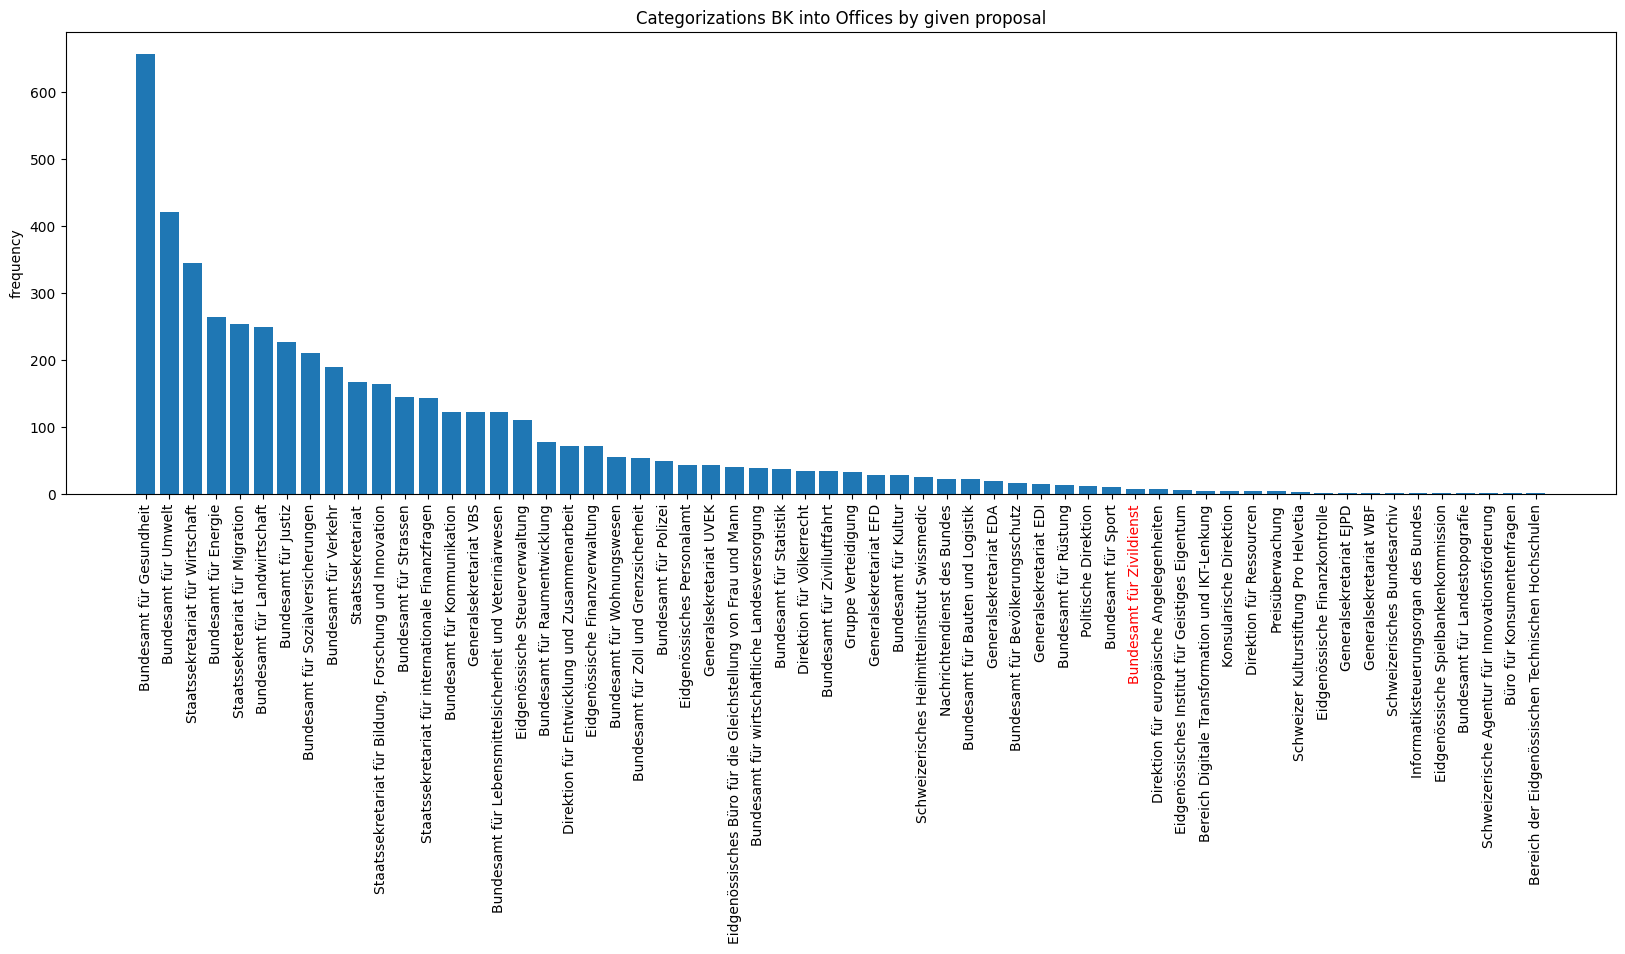

In [83]:
# Set up count data for histogram
counts = Counter(df["Office"])
common = counts.most_common()
labels = [item[0] for item in common]
number = [item[1] for item in common]
nbars = len(common)

# Configure plot
fig, ax = plt.subplots(figsize=(20,6))
plt.bar(np.arange(nbars), number, tick_label=labels)
plt.xticks(rotation=90)
plt.title("Categorizations BK into Offices by given proposal")
plt.ylabel("frequency")

# Set red categories
index_low_categories = list(map(lambda i: i < 10, number)).index(True)
ax.get_xticklabels()[index_low_categories].set_color("red")
fig.show()

In [79]:
df["Office"].value_counts()

Office
Bundesamt für Gesundheit                                         657
Bundesamt für Umwelt                                             421
Staatssekretariat für Wirtschaft                                 345
Bundesamt für Energie                                            264
Staatssekretariat für Migration                                  254
Bundesamt für Landwirtschaft                                     249
Bundesamt für Justiz                                             227
Bundesamt für Sozialversicherungen                               210
Bundesamt für Verkehr                                            190
Staatssekretariat                                                168
Staatssekretariat für Bildung, Forschung und Innovation          165
Bundesamt für Strassen                                           145
Staatssekretariat für internationale Finanzfragen                143
Generalsekretariat VBS                                           123
Bundesamt für Kommunikation

Text(0.5, 0, 'Häufigkeit der Kategorie')

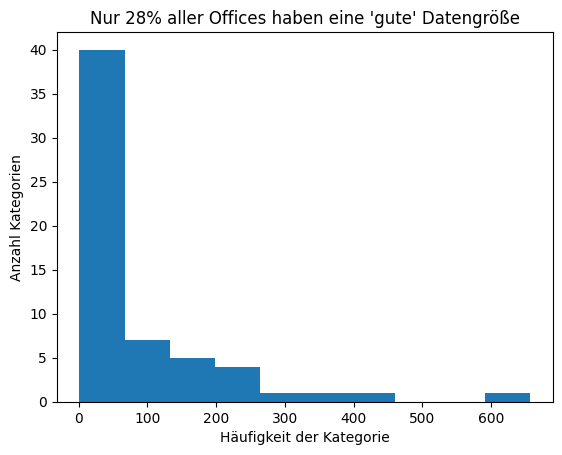

In [84]:
plt.hist(number)
plt.title("Nur 28% aller Offices haben eine 'gute' Datengröße")
plt.ylabel("Anzahl Kategorien")
plt.xlabel("Häufigkeit der Kategorie")

In [86]:
print(len(number))

60


In [95]:
large_categories = len(list(filter(lambda i: i > 100, number)))
print("large_categories", large_categories)

small_categories = len(list(filter(lambda i: i < 10, number)))
print("small_categories", small_categories)

large_categories 17
small_categories 18


In [96]:
print("large_categories share", large_categories/len(number))
print("small_categories share", small_categories/len(number))

large_categories share 0.2833333333333333
small_categories share 0.3


## Prepare training data
1. ~~remove low-count categories from training data~~
2. ~~remove irrelevant columns: Language, SubmittedBy~~
3. ~~evtl label (Bereich Digitale Transformation und IKT-Lenkung) vs short label (bkdti) matching?~~
4. ~~merge all text columns~~
5. possibilities: word preprocessing: stemming, stop words etc
6. ~~split into train/test/val~~
7. re-train model first batch if needed ~~(or try new model?)~~
8. ~~test training on titles & on full texts incl title~~

In [61]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer, DataCollatorWithPadding,
    AutoModelForSequenceClassification, TrainingArguments, Trainer
)
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
import numpy as np
import evaluate
import random

random.seed(10)


In [63]:
df = pd.read_csv('data/merged_export.csv', sep=";")
df['MergedText'] = df['Title'] + df['SubmittedText']

# Deal with occurrences of less than min_cut_off
min_cut_off = 41 # 10 (42 cat) or 35 (28 cat) or 41 (23 cat) or 79 (19 cat)

# remove them...
# d = df.loc[df['LeadingOfficeCode'].isin(df['LeadingOfficeCode'].value_counts().index[df['LeadingOfficeCode'].value_counts() > min_cut_off])]
# print(f"Reduced dataset from {len(df)} to {len(d)} data points.")

# ... or change to uncategorized
d = df
valid_codes = df['LeadingOfficeCode'].value_counts().index[df['LeadingOfficeCode'].value_counts() > min_cut_off]
d['LeadingOfficeCode'] = df['LeadingOfficeCode'].where(df['LeadingOfficeCode'].isin(valid_codes), 'Uncategorized')
print(f"Sorted {sum(d['LeadingOfficeCode']=='Uncategorized')} rows into 'Uncategorized'.")

# Create train & test split file
train, test_raw = train_test_split(d, test_size=0.25, random_state=42)
test, val = train_test_split(test_raw, test_size=0.25, random_state=42)

# comment out file generation to not change existing files
#train.to_csv('data/train.csv',index=False)
#test.to_csv('data/test.csv',index=False)
#val.to_csv('data/val.csv',index=False)
print(f"Split the dataset into {len(train)} samples for train, {len(test)} for test and {len(val)} for validation.")

Sorted 485 rows into 'Uncategorized'.
Split the dataset into 3654 samples for train, 913 for test and 305 for validation.


In [64]:
df = load_dataset("data", data_files={'train': 'train.csv', 'test': 'test.csv', 'validation': 'val.csv'}, encoding = "UTF-8")
print(df)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['CuriaId', 'Language', 'SubmittedBy', 'Title', 'SubmittedText', 'ReasonText', 'LeadingDepartmentCode', 'LeadingOfficeCode', 'Office', 'MergedText'],
        num_rows: 3654
    })
    test: Dataset({
        features: ['CuriaId', 'Language', 'SubmittedBy', 'Title', 'SubmittedText', 'ReasonText', 'LeadingDepartmentCode', 'LeadingOfficeCode', 'Office', 'MergedText'],
        num_rows: 913
    })
    validation: Dataset({
        features: ['CuriaId', 'Language', 'SubmittedBy', 'Title', 'SubmittedText', 'ReasonText', 'LeadingDepartmentCode', 'LeadingOfficeCode', 'Office', 'MergedText'],
        num_rows: 305
    })
})


In [69]:
# Initiate tokenizer & pytorch tensors
tokenizer = AutoTokenizer.from_pretrained('bert-base-german-cased') #'deepset/gbert-base')

# Label encoder using scikit-learn's LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(np.unique(df["train"]['LeadingOfficeCode']))

def transform_labels(label):
    label_raw = label['LeadingOfficeCode']
    num = le.transform([label_raw])
    np.save('classes_office.npy', le.classes_)
    # list(le.inverse_transform(labels)) # for inverse label mapping
    return {'labels': num}

def tokenize_data(df):
    return tokenizer(df["MergedText"], truncation=True, max_length=200)

# Apply a preprocessing function over the entire dataset (train & test)
tokenized_datasets = df.map(tokenize_data, batched=True)

# Remove columns & transform labels to int
remove_columns = ["Language", "SubmittedBy", "Office", "LeadingDepartmentCode"]
tokenized_datasets = tokenized_datasets.map(transform_labels, remove_columns=remove_columns)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# TODO: if wished figure out maybe hierarchical classifier?

Map:   0%|          | 0/913 [00:00<?, ? examples/s]

Map:   0%|          | 0/3654 [00:00<?, ? examples/s]

Map:   0%|          | 0/913 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

In [70]:
# Set up model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-german-cased', #'deepset/gbert-base', 
    num_labels=len(set(df["train"]["LeadingOfficeCode"]))
)

training_args = TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # test different rates: 3e-4, 1e-4, 5e-5, 3e-5 - best rate is default 5e-5
    #learning_rate=3e-5,
    output_dir='./results',
    logging_dir='./logs',
    num_train_epochs=4,
    evaluation_strategy="epoch",
    logging_steps=100,
    do_train=True,
    do_eval=True,
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)
    
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= tokenized_datasets["train"],
    eval_dataset= tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)
# TODO: evtl if wished get Dep Code from previous classifier & use for prediction
# TODO evaluate whether use GPU

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [71]:
trainer.train()

  0%|          | 0/916 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.2746, 'learning_rate': 4.4541484716157205e-05, 'epoch': 0.44}
{'loss': 1.3353, 'learning_rate': 3.9082969432314415e-05, 'epoch': 0.87}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 1.1326515674591064, 'eval_accuracy': 0.7009857612267251, 'eval_runtime': 12.5673, 'eval_samples_per_second': 72.649, 'eval_steps_per_second': 4.615, 'epoch': 1.0}
{'loss': 0.9191, 'learning_rate': 3.362445414847162e-05, 'epoch': 1.31}
{'loss': 0.79, 'learning_rate': 2.816593886462882e-05, 'epoch': 1.75}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.963087260723114, 'eval_accuracy': 0.7228915662650602, 'eval_runtime': 12.9699, 'eval_samples_per_second': 70.394, 'eval_steps_per_second': 4.472, 'epoch': 2.0}
{'loss': 0.5715, 'learning_rate': 2.2707423580786028e-05, 'epoch': 2.18}
{'loss': 0.3956, 'learning_rate': 1.7248908296943234e-05, 'epoch': 2.62}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 0.9526927471160889, 'eval_accuracy': 0.7415115005476451, 'eval_runtime': 12.9288, 'eval_samples_per_second': 70.618, 'eval_steps_per_second': 4.486, 'epoch': 3.0}
{'loss': 0.3654, 'learning_rate': 1.1790393013100438e-05, 'epoch': 3.06}
{'loss': 0.1942, 'learning_rate': 6.3318777292576415e-06, 'epoch': 3.49}
{'loss': 0.1812, 'learning_rate': 8.733624454148472e-07, 'epoch': 3.93}


  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 1.0080596208572388, 'eval_accuracy': 0.7393209200438116, 'eval_runtime': 13.28, 'eval_samples_per_second': 68.75, 'eval_steps_per_second': 4.367, 'epoch': 4.0}
{'train_runtime': 859.9242, 'train_samples_per_second': 16.997, 'train_steps_per_second': 1.065, 'train_loss': 0.7706809405676662, 'epoch': 4.0}


TrainOutput(global_step=916, training_loss=0.7706809405676662, metrics={'train_runtime': 859.9242, 'train_samples_per_second': 16.997, 'train_steps_per_second': 1.065, 'train_loss': 0.7706809405676662, 'epoch': 4.0})

In [72]:
results = trainer.evaluate()
print(results)

  0%|          | 0/58 [00:00<?, ?it/s]

{'eval_loss': 1.0080596208572388, 'eval_accuracy': 0.7393209200438116, 'eval_runtime': 12.6512, 'eval_samples_per_second': 72.167, 'eval_steps_per_second': 4.585, 'epoch': 4.0}


In [73]:
# Test Set Metrics
y_pred = trainer.predict(tokenized_datasets['test'])

y_pred_cat = np.argmax(y_pred.predictions, axis=1)
y_true_cat = tokenized_datasets["test"]["labels"]
class_report = metrics.classification_report(y_true_cat, y_pred_cat)
print(class_report)

  0%|          | 0/58 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.45      0.47        99
           1       0.64      0.60      0.62        15
           2       0.65      0.51      0.57        43
           3       0.87      0.87      0.87       120
           4       0.70      0.67      0.68        21
           5       0.79      0.68      0.73        40
           6       0.58      0.47      0.52        15
           7       0.50      0.33      0.40         6
           8       0.90      0.83      0.86        23
           9       0.56      0.62      0.59         8
          10       0.81      0.81      0.81        31
          11       0.67      0.70      0.69        44
          12       0.69      0.69      0.69        13
          13       0.91      0.93      0.92        44
          14       0.75      0.55      0.63        11
          15       0.69      0.83      0.75        24
          16       0.75      0.87      0.80        68
          17       0.96    

In [74]:
# Validation Set Metrics
y_pred = trainer.predict(tokenized_datasets['validation'])

y_pred_cat = np.argmax(y_pred.predictions, axis=1)
y_true_cat = tokenized_datasets["validation"]["labels"] # same as y_pred.label_ids
class_report = metrics.classification_report(y_true_cat, y_pred_cat)
print(y_pred.metrics)
print(class_report)
# if needed: 
# metrics.multilabel_confusion_matrix(y_true=y_true_cat,  y_pred=y_pred_cat)

  0%|          | 0/20 [00:00<?, ?it/s]

{'test_loss': 0.8761562705039978, 'test_accuracy': 0.780327868852459, 'test_runtime': 4.2678, 'test_samples_per_second': 71.465, 'test_steps_per_second': 4.686}
              precision    recall  f1-score   support

           0       0.58      0.56      0.57        27
           1       0.67      0.67      0.67         6
           2       0.50      0.75      0.60         8
           3       0.94      0.94      0.94        51
           4       0.90      0.90      0.90        10
           5       0.87      0.93      0.90        14
           6       0.50      0.50      0.50         4
           7       0.67      0.67      0.67         3
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         2
          10       1.00      0.50      0.67         6
          11       0.85      0.73      0.79        15
          12       1.00      1.00      1.00         2
          13       0.92      0.86      0.89        14
          14       0.86     

In [76]:
trainer.save_model("saved_model_office")